<a href="https://colab.research.google.com/github/24sureshkumar/Dominos---Predictive-Purchase-Order-System/blob/main/Dominos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
#!pip install pmdarima

In [69]:
#!pip install pandas==2.2.2 numpy==1.26.4 --force-reinstall

In [70]:
#!pip install prophet

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import holidays
import warnings
from prophet import Prophet
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape


In [72]:
sales_dataset = pd.read_csv('/content/drive/MyDrive/Dominos/Pizza_Sale - pizza_sales.csv')
ingredients_dataset = pd.read_csv('/content/drive/MyDrive/Dominos/Pizza_ingredients - Pizza_ingredients.csv')
print(sales_dataset.info())
print(f'missing values:\n\n{sales_dataset.isna().sum()}\n')
print(f'duplicate values:\n\n{sales_dataset.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB
None
missing values:

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time     

In [73]:
sales_dataset.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


# **Filling Total Price**

In [74]:
# Filling total price
sales_dataset['total_price'] = sales_dataset['total_price'].fillna(sales_dataset['unit_price'] * sales_dataset['quantity'])


In [75]:
print('ingredients dataset: \n')
print(ingredients_dataset.info())
print('sales data: \n')
print(sales_dataset.info())

ingredients dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB
None
sales data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_pric

# **Filling Pizza Category**

In [76]:
sales_dataset[sales_dataset['pizza_category'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
426,427,181,mexicana_l,1,3/1/2015,18:49:32,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,428,182,brie_carre_s,1,3/1/2015,18:50:10,23.65,23.65,S,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,429,182,peppr_salami_l,1,3/1/2015,18:50:10,20.75,20.75,L,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,430,183,napolitana_m,1,3/1/2015,18:54:55,16.00,16.00,M,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,431,183,spin_pesto_l,1,3/1/2015,18:54:55,20.75,20.75,L,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza


In [77]:
sales_dataset[sales_dataset['pizza_name_id'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
36,37,15,NaN,1,1/1/2015,13:33:00,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
37,38,15,NaN,1,1/1/2015,13:33:00,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza
38,39,15,NaN,1,1/1/2015,13:33:00,12.00,12.00,S,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic...",The Greek Pizza
39,40,16,NaN,1,1/1/2015,13:34:07,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
40,41,16,NaN,1,1/1/2015,13:34:07,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza


In [78]:
category = sales_dataset[['pizza_name_id','pizza_category']].dropna().drop_duplicates()
category_data = category.set_index('pizza_name_id')['pizza_category'].to_dict()
sales_dataset['pizza_category'] = sales_dataset['pizza_category'].fillna(sales_dataset['pizza_name_id'].map(category_data))
print(sales_dataset.isna().sum())

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients    13
pizza_name            7
dtype: int64


# **Filling Pizza Ingredient**

In [79]:
sales_dataset[sales_dataset['pizza_ingredients'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
580,581,254,five_cheese_l,1,4/1/2015,22:22:13,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
581,582,255,five_cheese_l,1,5/1/2015,11:23:35,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
582,583,255,green_garden_m,1,5/1/2015,11:23:35,16.0,16.0,M,Veggie,NaN,The Green Garden Pizza
583,584,255,hawaiian_l,1,5/1/2015,11:23:35,16.5,16.5,L,Classic,NaN,The Hawaiian Pizza
584,585,255,spinach_fet_m,1,5/1/2015,11:23:35,16.0,16.0,M,Veggie,NaN,The Spinach and Feta Pizza


In [80]:
sales_dataset[sales_dataset['pizza_name_id'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
36,37,15,NaN,1,1/1/2015,13:33:00,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
37,38,15,NaN,1,1/1/2015,13:33:00,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza
38,39,15,NaN,1,1/1/2015,13:33:00,12.00,12.00,S,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic...",The Greek Pizza
39,40,16,NaN,1,1/1/2015,13:34:07,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
40,41,16,NaN,1,1/1/2015,13:34:07,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza


In [81]:
ingredient = sales_dataset[['pizza_name_id','pizza_ingredients']].dropna().drop_duplicates()
ingredient_data = ingredient.set_index('pizza_name_id')['pizza_ingredients'].to_dict()
sales_dataset['pizza_ingredients'] = sales_dataset['pizza_ingredients'].fillna(sales_dataset['pizza_name_id'].map(ingredient_data))
print(sales_dataset.isna().sum())

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            7
dtype: int64


# **Filling Pizza Name**

In [82]:
sales_dataset[sales_dataset['pizza_name'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,689,303,pepperoni_s,1,5/1/2015,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,690,304,hawaiian_s,1,5/1/2015,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,691,304,mexicana_l,1,5/1/2015,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,692,305,pepperoni_l,1,5/1/2015,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,693,305,sicilian_s,1,5/1/2015,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN


In [83]:
sales_dataset[sales_dataset['pizza_name_id'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
36,37,15,NaN,1,1/1/2015,13:33:00,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
37,38,15,NaN,1,1/1/2015,13:33:00,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza
38,39,15,NaN,1,1/1/2015,13:33:00,12.00,12.00,S,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic...",The Greek Pizza
39,40,16,NaN,1,1/1/2015,13:34:07,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
40,41,16,NaN,1,1/1/2015,13:34:07,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza


In [84]:
pizza_name = sales_dataset[['pizza_name_id','pizza_name']].dropna().drop_duplicates()
pizza_name_data = sales_dataset.set_index('pizza_name_id')['pizza_name'].to_dict()
sales_dataset['pizza_name'] = sales_dataset['pizza_name'].fillna(sales_dataset['pizza_name_id'].map(pizza_name_data))
print(sales_dataset.isna().sum())

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
dtype: int64


# **Filling Pizza Name Id**

In [85]:
sales_dataset[sales_dataset['pizza_name_id'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
36,37,15,NaN,1,1/1/2015,13:33:00,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
37,38,15,NaN,1,1/1/2015,13:33:00,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza
38,39,15,NaN,1,1/1/2015,13:33:00,12.00,12.00,S,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic...",The Greek Pizza
39,40,16,NaN,1,1/1/2015,13:34:07,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
40,41,16,NaN,1,1/1/2015,13:34:07,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza


In [86]:
# TO filter perticular pizza name if not null pizza name id
pizza_name_to_filter = "The Soppressata Pizza"
filtered_sales = sales_dataset[sales_dataset['pizza_name_id'].notnull()]
filtered_sales = filtered_sales[filtered_sales['pizza_name'] == pizza_name_to_filter]
filtered_sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
162,163,70,soppressata_l,1,2/1/2015,11:38:51,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza
207,208,89,soppressata_l,1,2/1/2015,14:30:19,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza
236,237,101,soppressata_l,1,2/1/2015,17:51:33,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza
263,264,110,soppressata_l,1,2/1/2015,18:36:19,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza
465,466,197,soppressata_l,1,3/1/2015,21:47:48,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza


In [87]:
pizza_name_id = sales_dataset[['pizza_name_id','pizza_name']].dropna().drop_duplicates()
pizza_name_id_data = sales_dataset.set_index('pizza_name')['pizza_name_id'].to_dict()
sales_dataset['pizza_name_id'] = sales_dataset['pizza_name_id'].fillna(sales_dataset['pizza_name'].map(pizza_name_id_data))
sales_dataset.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


# **Filling Missing Values On Ingredient Dataset**

In [88]:
print(ingredients_dataset.isna().sum())
print(ingredients_dataset.columns)

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64
Index(['pizza_name_id', 'pizza_name', 'pizza_ingredients',
       'Items_Qty_In_Grams'],
      dtype='object')


In [89]:
ingredients_dataset[ingredients_dataset['Items_Qty_In_Grams'].isna()].head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [90]:
avg = ingredients_dataset.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()
avg_dict = avg.to_dict()
ingredients_dataset['Items_Qty_In_Grams'] = ingredients_dataset['Items_Qty_In_Grams'].fillna(ingredients_dataset['pizza_name_id'].map(avg_dict))
ingredients_dataset.isna().sum()

,0
pizza_name_id,0
pizza_name,0
pizza_ingredients,0
Items_Qty_In_Grams,0


In [91]:
merged_data = pd.merge(sales_dataset, ingredients_dataset, on = 'pizza_name_id', how = 'left')
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [92]:
merged_data[['pizza_ingredients_x','pizza_ingredients_y']].head()

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms


In [93]:
merged_data[['pizza_name_x','pizza_name_y']].head()

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza


In [94]:
merged_data.drop(columns = ['pizza_name_y','pizza_ingredients_y'],axis = 1,inplace = True)
merged_data.rename(columns = {'pizza_name_x':'pizza_name','pizza_ingredients_x':'pizza_ingredients'},inplace = True)
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0
1,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0
2,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0
3,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0
4,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0


In [95]:
merged_data.drop_duplicates(inplace = True)
merged_data.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [96]:
merged_data['order_date'].tail()

,order_date
267565,31-12-2015
267567,31-12-2015
267570,31-12-2015
267571,31-12-2015
267573,31-12-2015


In [97]:
def date_formet(data):
  for i in ['%Y-%m-%d', '%m/%d/%Y', '%d/%m/%Y', '%Y/%m/%d', '%d-%m-%Y']:
    try:
      return pd.to_datetime(data,format=i)
    except ValueError:
      continue
  return pd.NaT
merged_data['order_date'] = merged_data['order_date'].apply(date_formet)
merged_data.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [98]:
merged_data.shape

(187370, 13)

In [99]:
numerical_cols = merged_data.select_dtypes(include=['int64', 'float64']).columns

def clean_outliers_iqr(merged_data, numerical_cols):
    data = merged_data.copy()
    for col in numerical_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]  # Filter out outliers for this column
    return data

cleaned_data = clean_outliers_iqr(merged_data, numerical_cols)


In [100]:
cleaned_data.shape

(164754, 13)

# **Feature Engineering**

In [101]:
cleaned_data['day_of_week'] = cleaned_data['order_date'].dt.day_of_week
cleaned_data['day_name'] = cleaned_data['order_date'].dt.day_name()
cleaned_data['month'] = cleaned_data['order_date'].dt.month
cleaned_data['year'] = cleaned_data['order_date'].dt.year
cleaned_data['week'] = cleaned_data['order_date'].dt.isocalendar().week
cleaned_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,day_name,month,year,week
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,Thursday,1,2015,1
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,Thursday,1,2015,1
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,Thursday,1,2015,1
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,Thursday,1,2015,1
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,Thursday,1,2015,1


In [102]:
!pip install holidays

In [103]:
# Adding Holidays ------------
holidays = holidays.US(years = 2015)
cleaned_data['holidays'] = cleaned_data['order_date'].apply(lambda x: 1 if x in holidays else 0)
cleaned_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,day_name,month,year,week,holidays
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,Thursday,1,2015,1,1
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,Thursday,1,2015,1,1
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,Thursday,1,2015,1,1
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,Thursday,1,2015,1,1
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,Thursday,1,2015,1,1


In [104]:
cleaned_data[['order_date','holidays']]

,order_date,holidays
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
6,2015-01-01,1
...,...,...
267563,2015-12-31,0
267565,2015-12-31,0
267570,2015-12-31,0
267571,2015-12-31,0


In [105]:
print(cleaned_data[cleaned_data['holidays'] ==1][['order_date','day_name']])

       order_date  day_name
0      2015-01-01  Thursday
1      2015-01-01  Thursday
2      2015-01-01  Thursday
3      2015-01-01  Thursday
6      2015-01-01  Thursday
...           ...       ...
253975 2015-10-12    Monday
253978 2015-10-12    Monday
253979 2015-10-12    Monday
253980 2015-10-12    Monday
253981 2015-10-12    Monday

[4915 rows x 2 columns]


In [106]:
# Adding Promotions on Weekends -----------
cleaned_data['promotions'] = cleaned_data['day_name'].apply(lambda x: 1 if x in ['Saturday','Sunday'] else 0)
print(cleaned_data[['promotions','day_name','order_date']].head())

   promotions  day_name order_date
0           0  Thursday 2015-01-01
1           0  Thursday 2015-01-01
2           0  Thursday 2015-01-01
3           0  Thursday 2015-01-01
6           0  Thursday 2015-01-01


In [107]:
print(cleaned_data[cleaned_data['promotions'] == 1][['order_date','day_name']])

       order_date day_name
910    2015-02-01   Sunday
911    2015-02-01   Sunday
914    2015-02-01   Sunday
918    2015-02-01   Sunday
920    2015-02-01   Sunday
...           ...      ...
265236 2015-12-27   Sunday
265237 2015-12-27   Sunday
265239 2015-12-27   Sunday
265241 2015-12-27   Sunday
265246 2015-12-27   Sunday

[45220 rows x 2 columns]


In [108]:
cleaned_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,day_name,month,year,week,holidays,promotions
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,Thursday,1,2015,1,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,Thursday,1,2015,1,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,Thursday,1,2015,1,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,Thursday,1,2015,1,1,0
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,Thursday,1,2015,1,1,0


Dailly sales:

    order_date  quantity
0   2015-01-01       533
1   2015-01-02       637
2   2015-01-03       341
3   2015-01-04       444
4   2015-01-05       522
..         ...       ...
353 2015-12-27       296
354 2015-12-28       340
355 2015-12-29       250
356 2015-12-30       228
357 2015-12-31       586

[358 rows x 2 columns]



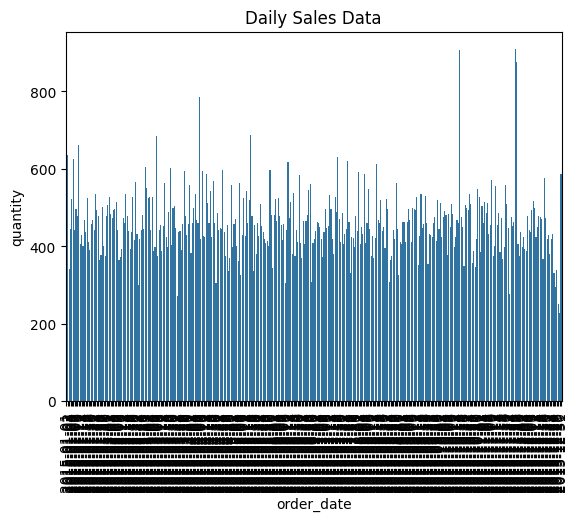

Top 10 selling pizza:

                           pizza_name  quantity  total_price
0          The Barbecue Chicken Pizza     10630    191216.50
4        The California Chicken Pizza      8944    155860.00
9               The Four Cheese Pizza      8422    143904.50
26            The Spicy Italian Pizza      7408    134116.00
30             The Thai Chicken Pizza      7252    129771.00
31  The Vegetables + Vegetables Pizza      7020    114023.75
12                 The Hawaiian Pizza      6957     92600.25
25        The Southwest Chicken Pizza      6807    118357.25
23                 The Sicilian Pizza      6773    105633.25
19            The Pepper Salami Pizza      5907    102473.50



<ipython-input-109-6811b65835f3>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = top10_selling_pizza,x = 'pizza_name',y = 'quantity', palette = 'viridis')


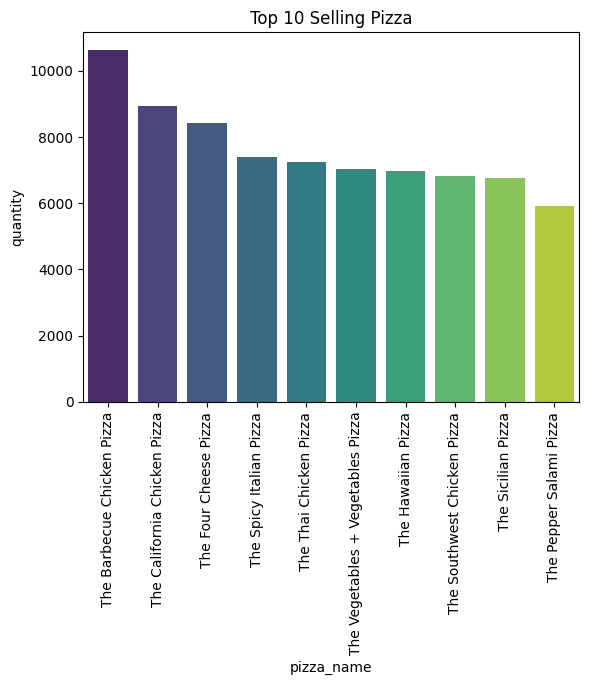

Holidays highest selling pizza:

                           pizza_name  quantity
0          The Barbecue Chicken Pizza       337
4        The California Chicken Pizza       252
9               The Four Cheese Pizza       248
30             The Thai Chicken Pizza       240
31  The Vegetables + Vegetables Pizza       212
12                 The Hawaiian Pizza       210
14          The Italian Supreme Pizza       208
25        The Southwest Chicken Pizza       201
26            The Spicy Italian Pizza       196
29         The Spinach and Feta Pizza       188


<ipython-input-109-6811b65835f3>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = holidays_sales, x = 'pizza_name', y = 'quantity',palette = 'viridis')


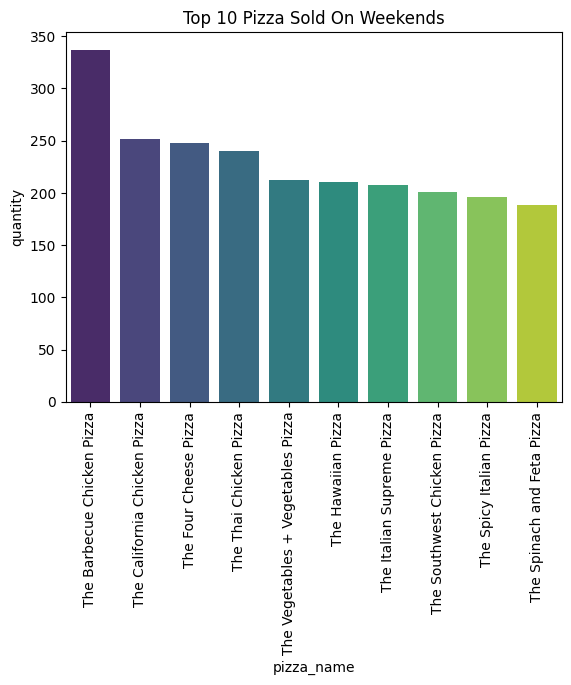

Sales Over Time:

    order_date  total_price
0   2015-01-01      9001.25
1   2015-01-02     10919.30
2   2015-01-03      5596.60
3   2015-01-04      7218.00
4   2015-01-05      8772.85
..         ...          ...
353 2015-12-27      4786.60
354 2015-12-28      5502.10
355 2015-12-29      4374.10
356 2015-12-30      3804.00
357 2015-12-31      9689.20

[358 rows x 2 columns]



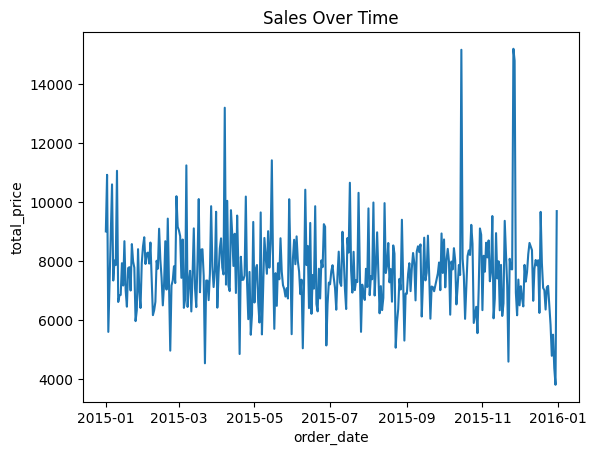

Monthly Sales:

    month  quantity  total_price
0       1     14526    241226.70
2       3     14448    241065.30
10     11     14394    239422.80
3       4     14265    238061.60
6       7     14142    235882.90
7       8     13939    232348.10
9      10     13748    229874.55
5       6     13720    229227.95
4       5     13566    227948.40
1       2     12951    216627.40
8       9     12759    213511.60
11     12     12296    205663.45



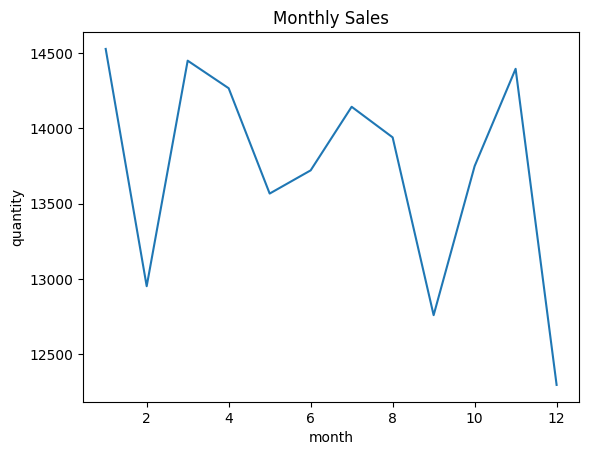

<ipython-input-109-6811b65835f3>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'holidays',y = 'total_price',data = week_and_weekend, palette = 'coolwarm')


Holidays vs Non-Holidays Sales:

   holidays  total_price
0         0   2668283.85
1         1     82576.90



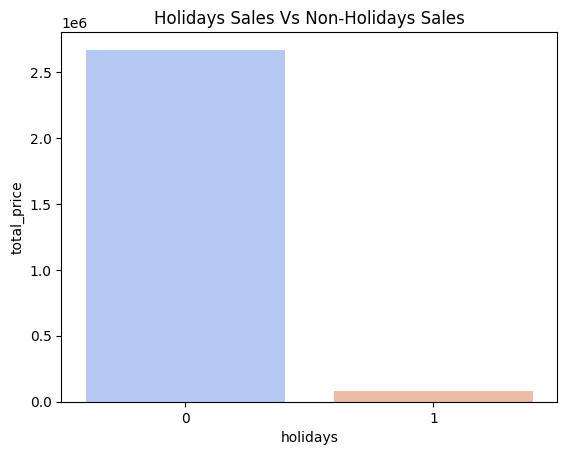

<ipython-input-109-6811b65835f3>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'pizza_category', y = 'quantity', data = category_sales, palette = 'coolwarm')


Sales On Pizza Category:

  pizza_category  quantity
0        Chicken     40664
1        Classic     38336
2        Supreme     41892
3         Veggie     43862



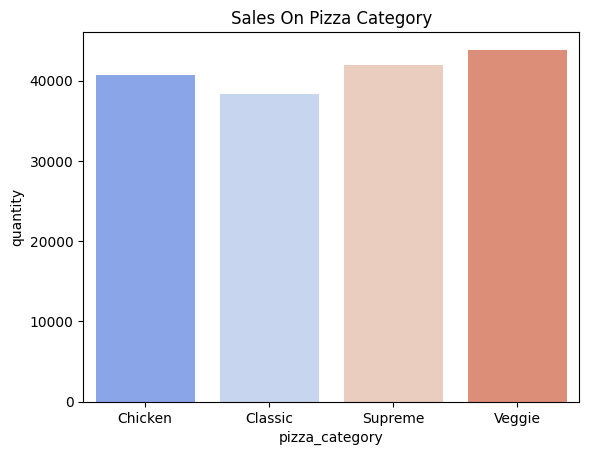

<ipython-input-109-6811b65835f3>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'pizza_size', y = 'quantity', data = pizza_size, palette = 'coolwarm')


Sales On Pizza Size:

  pizza_size  quantity
0          L     62851
1          M     53878
2          S     45881
3         XL      2144



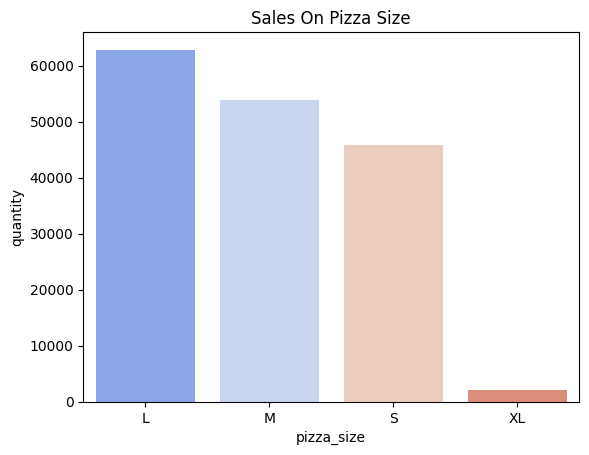

Weekly Sales:

    day_name  quantity
0     Friday       397
1     Monday       527
2   Saturday       685
3     Sunday       376
4   Thursday       388
5    Tuesday       442
6  Wednesday       527



<ipython-input-109-6811b65835f3>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'day_name', y = 'quantity',data = day_sales, palette = 'coolwarm')


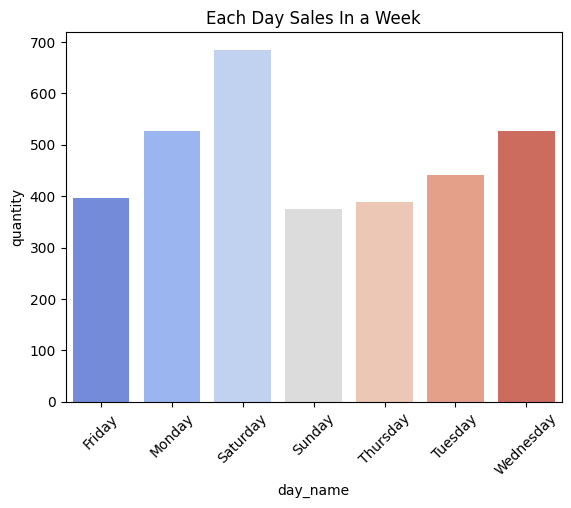

In [109]:
# Daily sales -------------------
daily_sales = cleaned_data.groupby('order_date')['quantity'].sum().reset_index()
print(f'Dailly sales:\n\n{daily_sales}\n')
sns.barplot(data = daily_sales,x = 'order_date',y = 'quantity')
plt.title('Daily Sales Data')
plt.xticks(rotation = 90)
plt.show()

# Top 10 selling pizza ------------
pizza_sales = cleaned_data.groupby('pizza_name')[['quantity','total_price']].sum().reset_index().sort_values(by = 'quantity',ascending = False)
top10_selling_pizza = pizza_sales.head(10)
print(f'Top 10 selling pizza:\n\n{top10_selling_pizza}\n')
sns.barplot(data = top10_selling_pizza,x = 'pizza_name',y = 'quantity', palette = 'viridis')
plt.title('Top 10 Selling Pizza')
plt.xticks(rotation = 90)
plt.show()

# Holidays sales -------------
holidays_sales = cleaned_data[cleaned_data['holidays'] == 1].groupby('pizza_name')['quantity'].sum().reset_index().sort_values(by = 'quantity',ascending =False).head(10)
print(f'Holidays highest selling pizza:\n\n{holidays_sales}')
sns.barplot(data = holidays_sales, x = 'pizza_name', y = 'quantity',palette = 'viridis')
plt.title('Top 10 Pizza Sold On Weekends')
plt.xticks(rotation = 90)
plt.show()

# Sales over time -----------
sales_over_time = cleaned_data.groupby('order_date')['total_price'].sum().reset_index()
print(f'Sales Over Time:\n\n{sales_over_time}\n')
sns.lineplot(data = sales_over_time,x = 'order_date',y = 'total_price')
plt.title('Sales Over Time')
plt.show()

# Monthly sales -----------
monthly_sales = cleaned_data.groupby('month')[['quantity','total_price']].sum().reset_index().sort_values(by = 'quantity',ascending = False)
print(f'Monthly Sales:\n\n{monthly_sales}\n')
sns.lineplot(data = monthly_sales, x = 'month', y = 'quantity')
plt.title('Monthly Sales')
plt.show()

# Weekdays vs Weekends sales -------------
week_and_weekend = cleaned_data.groupby('holidays')['total_price'].sum().reset_index() # Group by 'holidays' and calcu
sns.barplot(x = 'holidays',y = 'total_price',data = week_and_weekend, palette = 'coolwarm')
print(f'Holidays vs Non-Holidays Sales:\n\n{week_and_weekend}\n')
plt.title('Holidays Sales Vs Non-Holidays Sales')
plt.show()

# Sales On Pizza Category -------------
category_sales = cleaned_data.groupby('pizza_category')['quantity'].sum().reset_index()
sns.barplot(x = 'pizza_category', y = 'quantity', data = category_sales, palette = 'coolwarm')
print(f'Sales On Pizza Category:\n\n{category_sales}\n')
plt.title('Sales On Pizza Category')
plt.show()

# Sales on pizza Size -------------
pizza_size = cleaned_data.groupby('pizza_size')['quantity'].sum().reset_index()
sns.barplot(x = 'pizza_size', y = 'quantity', data = pizza_size, palette = 'coolwarm')
print(f'Sales On Pizza Size:\n\n{pizza_size}\n')
plt.title('Sales On Pizza Size')
plt.show()

# Weekly sales ---------------
day_sales = cleaned_data[cleaned_data['week'] == 10].groupby('day_name')['quantity'].sum().reset_index()
print(f'Weekly Sales:\n\n{day_sales}\n')
sns.barplot(x = 'day_name', y = 'quantity',data = day_sales, palette = 'coolwarm')
plt.title('Each Day Sales In a Week')
plt.xticks(rotation = 45)
plt.show()

In [110]:
!pip install statsmodels

# **WEEKLY PIZZA SALES FORECASTING**

## ***ARIMA MODEL***

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

Best ARIMA Parameters: (0, 0, 5), Best MAPE: 0.2027


<ipython-input-111-a3dd6e33f755>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Predicted Sales for Next Week: {next_week_prediction[0]:.2f}")


Predicted Sales for Next Week: 3119.06
order_date
2015-10-19    2973.735940
2015-10-26    2701.297121
2015-11-02    3196.420663
2015-11-09    3231.051198
2015-11-16    3204.619999
2015-11-23    3166.993304
2015-11-30    3166.993304
2015-12-07    3166.993304
2015-12-14    3166.993304
2015-12-21    3166.993304
2015-12-28    3166.993304
Name: predicted_mean, dtype: float64


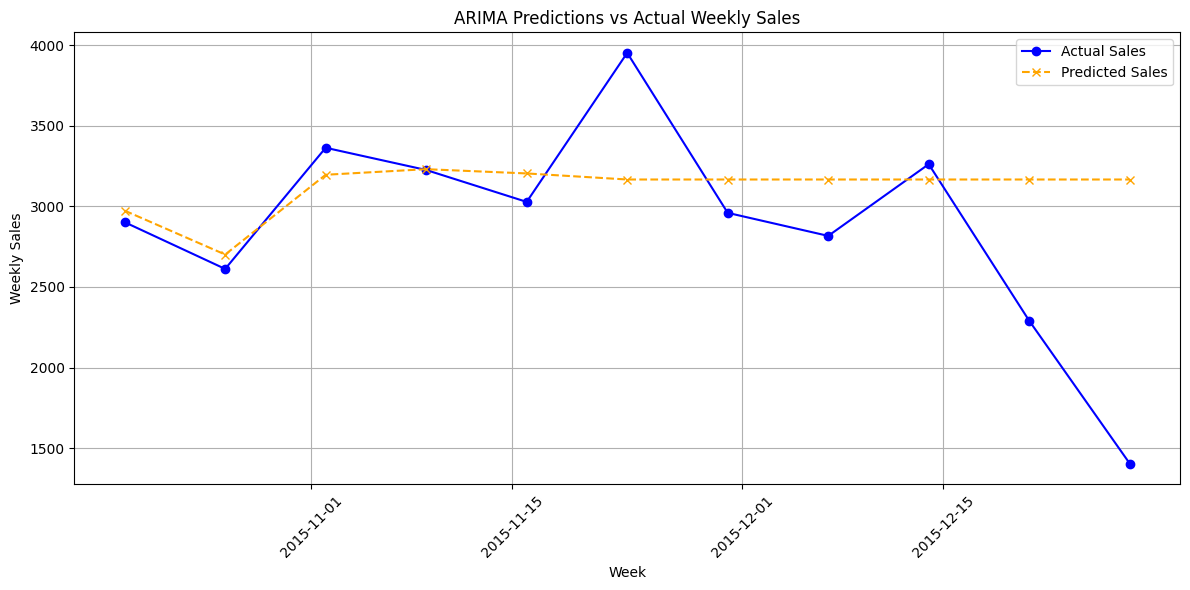

In [111]:
# Step 1: Prepare Weekly Sales Data
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])  # Ensure datetime
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Aggregate data to weekly sales
pizza_sales_weekly = prepare_weekly_sales(cleaned_data)

# Step 2: Train-Test Split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]
def mape(actual,prediction):
  return np.mean(np.abs(actual - prediction) / actual)

# Step 3: Tune ARIMA Model
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None
    for p,d,q in itertools.product(p_values,d_values,q_values):
      try:
          model = ARIMA(train, order=(p, d, q)).fit()
          predictions = model.forecast(steps=len(test))
          mape_score = mape(test, predictions)
          if mape_score < best_score:
              best_score, best_params, best_predictions = mape_score, (p, d, q), predictions
      except:
          continue

    if best_params is None:
        best_params = (0, 1, 1)  # Default parameters
        print("No valid ARIMA parameters found. Using default: (0, 1, 1)")

    print(f"Best ARIMA Parameters: {best_params}, Best MAPE: {best_score:.4f}")
    return best_predictions, best_score, best_params

# Tune ARIMA model
p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Step 4: Predict Weekly Sales for Future Periods
best_model = ARIMA(pizza_sales_weekly, order=best_params).fit()
next_week_prediction = best_model.forecast(steps=1)  # Forecast for 1 week

# Display Prediction
print(f"Predicted Sales for Next Week: {next_week_prediction[0]:.2f}")

# Step 5: Visualize Predictions
arima_predictions = pd.Series(arima_predictions, index=test.index)
print(arima_predictions)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## ***SARIMA Model***

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Best SARIMA Model MAPE: 0.2282
Predictions:
order_date
2015-10-19    3067.417887
2015-10-26    3349.208986
2015-11-02    3230.107926
2015-11-09    2886.891859
2015-11-16    3181.119807
2015-11-23    3229.622917
2015-11-30    3293.304155
2015-12-07    3147.205736
2015-12-14    3374.239895
2015-12-21    3261.321539
2015-12-28    2953.371024
Name: predicted_mean, dtype: float64


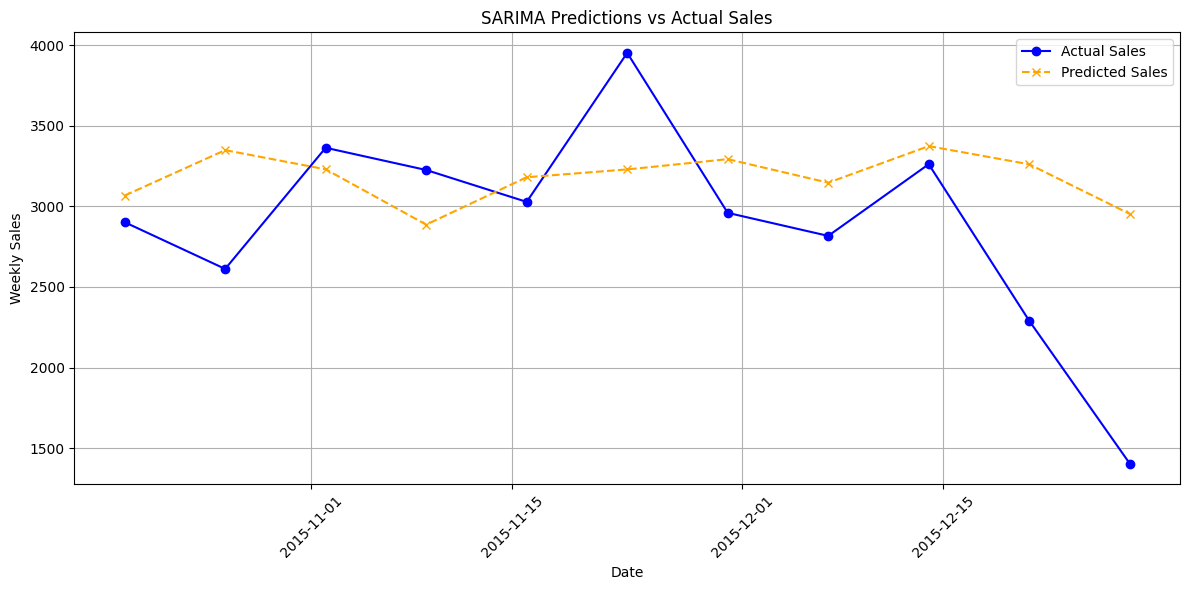

In [112]:
# To predict weekly pizza sales quantity ------------------
# Pizza sales by week
def prepare_weekly_sales(df):
    # merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(cleaned_data)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape

# Train and evaluate the SARIMA model
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## ***PROPHET Model***

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps0jlz_0k/hqk315xt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps0jlz_0k/j8qkdhph.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52276', 'data', 'file=/tmp/tmps0jlz_0k/hqk315xt.json', 'init=/tmp/tmps0jlz_0k/j8qkdhph.json', 'output', 'file=/tmp/tmps0jlz_0k/prophet_model9_nf98un/prophet_model-20250512041044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:10:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:10:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Figure(1000x600)


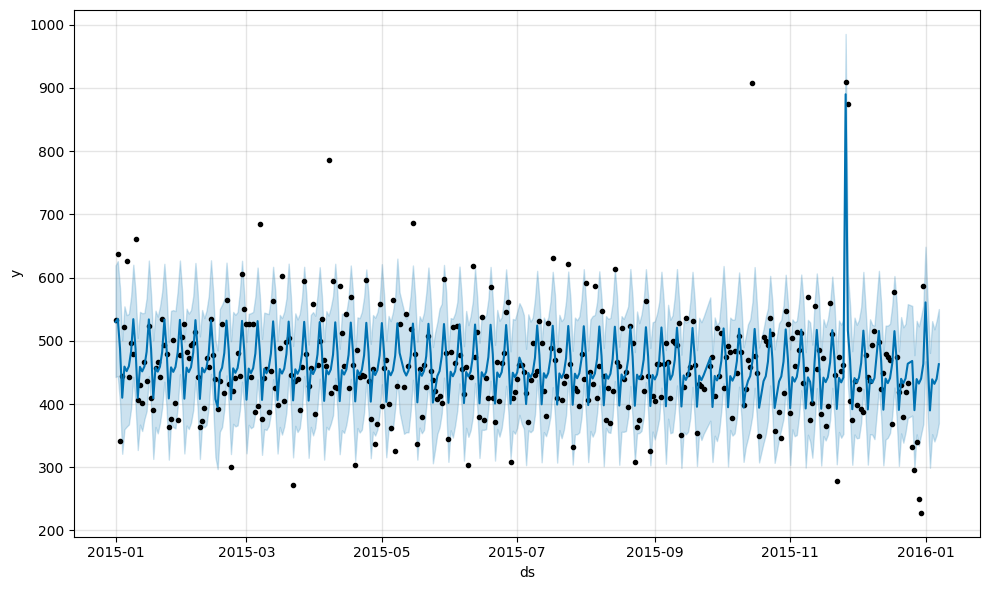

In [113]:
# To forcast next one week pizza sales quantity
data = daily_sales.rename(columns = {'order_date': 'ds','quantity':'y'}) # ds ----- Dates
model = Prophet()                                                        # y ------ Target
model.add_country_holidays(country_name = 'US')                          # Add holidays
model.fit(data)                                                          # Fit the Model
future = model.make_future_dataframe(periods = 7, freq = 'D')            # 7 periods in a year future predict
forecast = model.predict(future)                                         # y_hat upper and y_hat lower is 'uncertainty bound or tolerance bound'
print(model.plot(forecast))                                              # Plot forecasting

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps0jlz_0k/0s5miow2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps0jlz_0k/3fqm4q2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14059', 'data', 'file=/tmp/tmps0jlz_0k/0s5miow2.json', 'init=/tmp/tmps0jlz_0k/3fqm4q2z.json', 'output', 'file=/tmp/tmps0jlz_0k/prophet_modelxx9m6z44/prophet_model-20250512041103.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:11:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:11:04 - cmdstanpy - INFO - Chai

prophet mape score :0.2257
ds
2015-10-19    3164.717733
2015-10-26    3164.702865
2015-11-02    3164.687996
2015-11-09    3164.673128
2015-11-16    3164.658259
2015-11-23    3164.643391
2015-11-30    3164.628522
2015-12-07    3164.613654
2015-12-14    3164.598785
2015-12-21    3164.583917
2015-12-28    3164.569048
dtype: float64


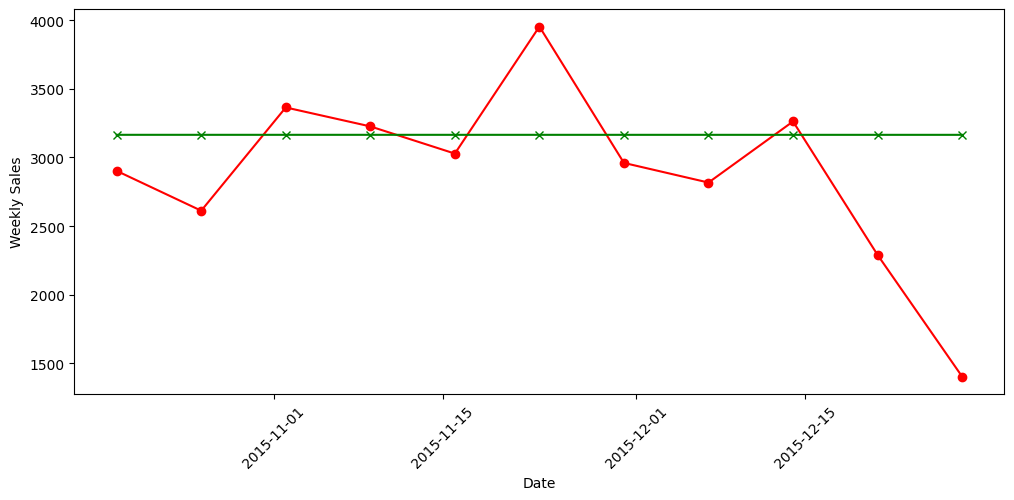

In [114]:
# To predict weekly pizza sales
# Seperate the Date and quantity
weekly_sales = cleaned_data.groupby(cleaned_data['order_date'].dt.to_period('W').apply(lambda x: x.start_time))['quantity'].sum().reset_index()
weekly_sales.rename(columns = {'order_date': 'ds','quantity': 'y'}, inplace = True)
# Test,Train split
train_size = int(0.8 * len(weekly_sales))
train, test = weekly_sales[:train_size],weekly_sales[train_size:]
# Model Fit
model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods = len(test), freq = 'W')
forcast = model.predict(future)
prediction = forcast['yhat'][-len(test):].values
# mape
def mape(actual,predicted):
  return np.mean(np.abs((actual - prediction) / actual))

prophet_mape = mape(test['y'].values,prediction)
print(f'prophet mape score :{prophet_mape:.4f}')

prophet_prediction = pd.Series(prediction, index = test['ds'])
print(prophet_prediction)
# Visualization
plt.figure(figsize = (12,5))
plt.plot(test['ds'], test['y'], label = 'Actual', color = 'red',marker = 'o')
plt.plot(prophet_prediction.index, prediction, label = 'Predicted', color = 'green', marker = 'x')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation = 45)
plt.show()

# **WEEKLY PIZZA SALES FOR EACH PIZZA TYPE**

## ***ARIMA Model***

In [115]:
# weekly pizza sales --------
def weekly_sales_by_pizza(df):
  df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
  weekly_sales_by_pizza = df.groupby(['week','pizza_name_id'])['quantity'].sum().reset_index()
  weekly_sales_by_pizza.set_index('week',inplace = True)
  return weekly_sales_by_pizza
weekly_sales_by_pizza = weekly_sales_by_pizza(cleaned_data)

# forecast pizza type ------------
def forecast_each_pizza_type(train,pizza_type,periods=1):
  model = ARIMA(train,order = (1,1,1))
  arima_model = model.fit()
  forecast = arima_model.forecast(steps=periods)
  return pizza_type,forecast.tolist()

# forecast each pizza type on next week -----------------
def next_week_forecast(weekly_sales_by_pizza,periods=1):
  pizza_type_forecast = {}
  last_week = weekly_sales_by_pizza.index.max()
  next_week_start = last_week + pd.Timedelta(weeks=1)
  next_week_end = next_week_start + pd.Timedelta(days=6)

  for pizza_type in weekly_sales_by_pizza['pizza_name_id'].unique():
    # Test and train data splid --------
    train = weekly_sales_by_pizza[weekly_sales_by_pizza['pizza_name_id']==pizza_type]['quantity']
    pizza_type,forecast = forecast_each_pizza_type(train,pizza_type,periods)
    if forecast is not None:
      pizza_type_forecast[pizza_type] = forecast
    else:
      print(f'Forecast failed for pizza type {pizza_type}')
  return pizza_type_forecast,next_week_start,next_week_end
next_week_pizza_forecast,next_week_start,next_week_end = next_week_forecast(weekly_sales_by_pizza)

print(f'Forecasted pizza sales from {next_week_start.date()} to {next_week_end.date()}')
forecast_quantity = 0
for pizza_type, forecast in next_week_pizza_forecast.items():
    forecast_value = int(forecast[0])
    print(f' {pizza_type}: {forecast_value} pizzas')
    forecast_quantity += forecast_value

print(f'Total quantity of units sold in the predicted week: {forecast_quantity}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

Forecasted pizza sales from 2016-01-04 to 2016-01-10
 bbq_ckn_l: 82 pizzas
 bbq_ckn_m: 73 pizzas
 bbq_ckn_s: 25 pizzas
 big_meat_s: 61 pizzas
 brie_carre_s: 35 pizzas
 calabrese_l: 20 pizzas
 calabrese_m: 37 pizzas
 cali_ckn_l: 69 pizzas
 cali_ckn_m: 57 pizzas
 cali_ckn_s: 36 pizzas
 ckn_alfredo_l: 11 pizzas
 ckn_alfredo_m: 48 pizzas
 ckn_alfredo_s: 9 pizzas
 ckn_pesto_l: 24 pizzas
 ckn_pesto_m: 15 pizzas
 ckn_pesto_s: 26 pizzas
 classic_dlx_l: 15 pizzas
 classic_dlx_m: 46 pizzas
 classic_dlx_s: 45 pizzas
 five_cheese_l: 46 pizzas
 four_cheese_l: 117 pizzas
 four_cheese_m: 40 pizzas
 green_garden_l: 8 pizzas
 green_garden_m: 23 pizzas
 green_garden_s: 39 pizzas
 hawaiian_l: 52 pizzas
 hawaiian_m: 27 pizzas
 hawaiian_s: 49 pizzas
 ital_cpcllo_l: 39 pizzas
 ital_cpcllo_m: 17 pizzas
 ital_cpcllo_s: 20 pizzas
 ital_supr_l: 39 pizzas
 ital_supr_m: 36 pizzas
 ital_supr_s: 17 pizzas
 ital_veggie_m: 39 pizzas
 ital_veggie_s: 17 pizzas
 mediterraneo_l: 31 pizzas
 mediterraneo_s: 23 pizzas
 mexi

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarni

## ***SARIMA Model***

In [116]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Aggregate Weekly Sales by Pizza Type
def prepare_weekly_sales_by_pizza(df):
    cleaned_data['order_date'] = pd.to_datetime(cleaned_data['order_date'])
    cleaned_data['week'] = cleaned_data['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = cleaned_data.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

# 2. Forecast Sales for a Single Pizza Type
def forecast_sales(train_data, periods=1):
    model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=periods)
    return forecast

# 3. Forecast Weekly Sales for All Pizza Types
def forecast_weekly_sales_by_pizza_type(weekly_sales_by_pizza, periods=1):
    pizza_forecasts = {}
    next_week_start = weekly_sales_by_pizza.index.max() + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Pivot table for easier slicing by pizza type
    sales_pivot = weekly_sales_by_pizza.pivot_table(
        index='week', columns='pizza_name_id', values='quantity', fill_value=0)

    # Forecast for each pizza type
    for pizza_type in sales_pivot.columns:
        pizza_data = sales_pivot[pizza_type]

        # Train/test split
        train_size = int(len(pizza_data) * 0.8)
        train_data = pizza_data[:train_size]

        # Forecast the next week's sales
        forecast = forecast_sales(train_data, periods=periods)
        pizza_forecasts[pizza_type] = int(forecast[0])  # Take the first forecasted value

    return pizza_forecasts, next_week_start, next_week_end

# Aggregate weekly sales
pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(cleaned_data)

# Forecast for next week
next_week_forecasts, next_week_start, next_week_end = forecast_weekly_sales_by_pizza_type(
    pizza_sales_weekly_by_pizza, periods=1
)

# Display results
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_forecasts.items():
    print(f"{pizza_type}: {forecast} pizzas")
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
<ipython-input-116-82b9a43970ed>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pizza_forecasts[pizza_type] = int(forecast[0])  # Take the first forecasted value
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 68 pizzas
bbq_ckn_m: 94 pizzas
bbq_ckn_s: 30 pizzas
big_meat_s: 61 pizzas
brie_carre_s: 39 pizzas
calabrese_l: 15 pizzas
calabrese_m: 35 pizzas
calabrese_s: 4 pizzas
cali_ckn_l: 72 pizzas
cali_ckn_m: 47 pizzas
cali_ckn_s: 36 pizzas
ckn_alfredo_l: 9 pizzas
ckn_alfredo_m: 50 pizzas
ckn_alfredo_s: 7 pizzas
ckn_pesto_l: 27 pizzas
ckn_pesto_m: 14 pizzas
ckn_pesto_s: 16 pizzas
classic_dlx_l: 17 pizzas
classic_dlx_m: 45 pizzas
classic_dlx_s: 38 pizzas
five_cheese_l: 49 pizzas
four_cheese_l: 141 pizzas
four_cheese_m: 42 pizzas
green_garden_l: 12 pizzas
green_garden_m: 37 pizzas
green_garden_s: 37 pizzas
hawaiian_l: 48 pizzas
hawaiian_m: 18 pizzas
hawaiian_s: 48 pizzas
ital_cpcllo_l: 40 pizzas
ital_cpcllo_m: 27 pizzas
ital_cpcllo_s: 32 pizzas
ital_supr_l: 43 pizzas
ital_supr_m: 40 pizzas
ital_supr_s: 10 pizzas
ital_veggie_l: 22 pizzas
ital_veggie_m: 37 pizzas
ital_veggie_s: 14 pizzas
mediterraneo_l: 38 pizzas
mediterraneo_m: 38 

<ipython-input-116-82b9a43970ed>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pizza_forecasts[pizza_type] = int(forecast[0])  # Take the first forecasted value


## ***PROPHET Model***

In [117]:
# Function to forecast sales for each pizza type using Prophet
def forecast_sales_per_pizza_type_prophet(pizza_type, train, periods=1):
    # Prepare the data for Prophet
    train_prophet = train.reset_index().rename(columns={'week': 'ds', 'quantity': 'y'})

    # Fit the Prophet model
    model = Prophet()
    model.fit(train_prophet)

    # Create a DataFrame to hold the future dates
    future = model.make_future_dataframe(periods=periods)

    # Forecasting
    forecast = model.predict(future)
    return pizza_type, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

# Forecasting next week's sales for each pizza type using Prophet
def forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza, periods=7):
    pizza_type_forecasts = {}

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Train-test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]

        # Forecast sales using Prophet
        pizza_type, forecast = forecast_sales_per_pizza_type_prophet(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast['yhat'].sum()  # Total forecasted sales for the week
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, next_week_start, next_week_end

# Forecasting pizza sales for the next week using Prophet
next_week_pizza_sales_forecasts_prophet, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = sum(next_week_pizza_sales_forecasts_prophet.values())

for pizza_type, forecast in next_week_pizza_sales_forecasts_prophet.items():
    print(f'{pizza_type}: {int(forecast)} pizzas')

print(f"Total quantity of units sold in the predicted week: {int(total_forecasted_quantity)} pizzas")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps0jlz_0k/ardujsb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps0jlz_0k/sis2xa4b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46471', 'data', 'file=/tmp/tmps0jlz_0k/ardujsb8.json', 'init=/tmp/tmps0jlz_0k/sis2xa4b.json', 'output', 'file=/tmp/tmps0jlz_0k/prophet_modellngbpqpp/prophet_model-20250512041246.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:46 - cmdstanpy - INFO - Chai

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 550 pizzas
bbq_ckn_m: 617 pizzas
bbq_ckn_s: 187 pizzas
big_meat_s: 476 pizzas
brie_carre_s: 258 pizzas
calabrese_l: 150 pizzas
calabrese_m: 276 pizzas
cali_ckn_l: 472 pizzas
cali_ckn_m: 432 pizzas
cali_ckn_s: 262 pizzas
ckn_alfredo_l: 110 pizzas
ckn_alfredo_m: 391 pizzas
ckn_alfredo_s: 72 pizzas
ckn_pesto_l: 144 pizzas
ckn_pesto_m: 110 pizzas
ckn_pesto_s: 160 pizzas
classic_dlx_l: 120 pizzas
classic_dlx_m: 308 pizzas
classic_dlx_s: 325 pizzas
five_cheese_l: 328 pizzas
four_cheese_l: 853 pizzas
four_cheese_m: 294 pizzas
green_garden_l: 70 pizzas
green_garden_m: 171 pizzas
green_garden_s: 305 pizzas
hawaiian_l: 359 pizzas
hawaiian_m: 190 pizzas
hawaiian_s: 366 pizzas
ital_cpcllo_l: 301 pizzas
ital_cpcllo_m: 144 pizzas
ital_cpcllo_s: 121 pizzas
ital_supr_l: 276 pizzas
ital_supr_m: 350 pizzas
ital_supr_s: 99 pizzas
ital_veggie_m: 252 pizzas
ital_veggie_s: 121 pizzas
mediterraneo_l: 235 pizzas
mediterraneo_s: 200 pizzas
mexi

Best ARIMA Parameters: (4, 2, 4), Best MAPE: 0.1979, AIC: 605.88


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-118-20a9bc35f6bf>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

Predicted Sales for Next Week: 2074.94


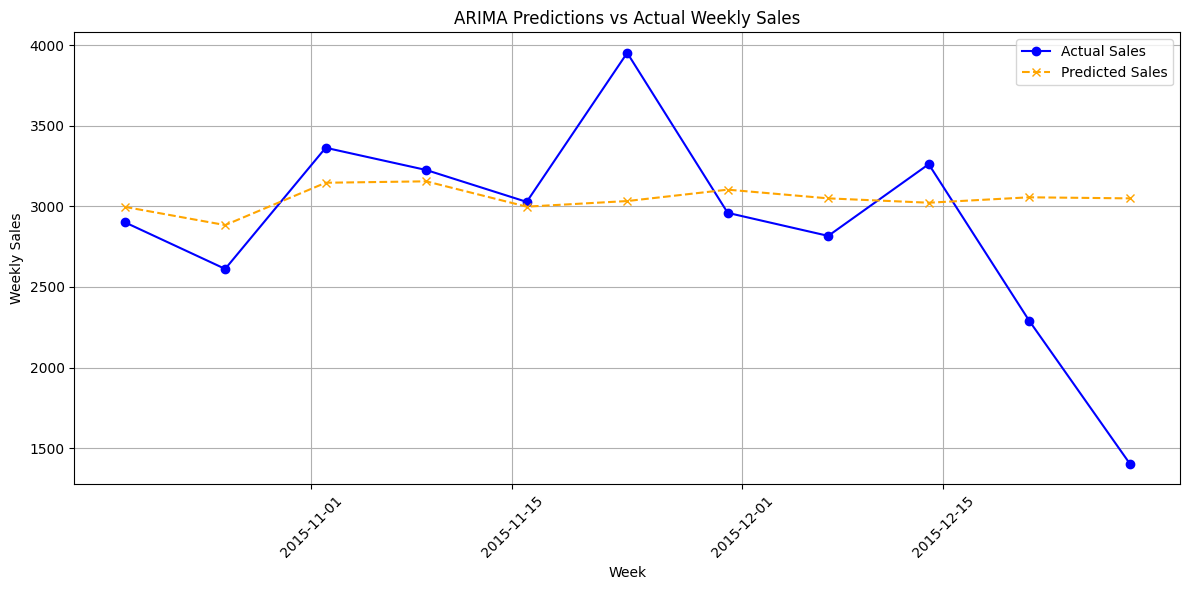

In [118]:
# Import necessary libraries
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed

# Step 1: Prepare Weekly Sales Data
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])  # Ensure datetime format
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Load Data and Aggregate Weekly Sales
pizza_sales_weekly = prepare_weekly_sales(cleaned_data)

# Step 2: Train-Test Split (80% Train, 20% Test)
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Step 3: Define MAPE Function (Handles Zero Values)
def mape(actual, prediction):
    return np.mean(np.abs(actual - prediction) / np.where(actual == 0, 1, actual))

# Step 4: ARIMA Hyperparameter Tuning with Parallel Processing
def evaluate_arima(train, test, p, d, q):
    try:
        model = ARIMA(train, order=(p, d, q)).fit()
        predictions = model.forecast(steps=len(test))
        mape_score = mape(test, predictions)
        aic_score = model.aic
        return (p, d, q), mape_score, predictions, aic_score
    except:
        return None

def tune_arima_model_parallel(train, test, p_values, d_values, q_values):
    param_grid = list(itertools.product(p_values, d_values, q_values))
    results = Parallel(n_jobs=-1)(delayed(evaluate_arima)(train, test, p, d, q) for p, d, q in param_grid)

    best_result = min((r for r in results if r is not None), key=lambda x: x[1], default=None)

    if best_result:
        best_params, best_score, best_predictions, best_aic = best_result
        print(f"Best ARIMA Parameters: {best_params}, Best MAPE: {best_score:.4f}, AIC: {best_aic:.2f}")
        return best_predictions, best_score, best_params
    else:
        print("No valid ARIMA parameters found.")
        return None, None, (0, 1, 1)

# Step 5: Tune ARIMA Model
p_values, d_values, q_values = range(0, 6), range(0, 3), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model_parallel(train, test, p_values, d_values, q_values)

# Step 6: Train Final Model with Best Parameters and Forecast Future Sales
best_model = ARIMA(pizza_sales_weekly, order=best_params).fit()
next_week_prediction = best_model.forecast(steps=1)  # Predict next week's sales

# Display Prediction
print(f"Predicted Sales for Next Week: {next_week_prediction[0]:.2f}")

# Step 7: Visualize Predictions
arima_predictions = pd.Series(arima_predictions, index=test.index)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [119]:
import pickle

# Save the best ARIMA model
with open('/content/drive/MyDrive/Dominos/best_arima_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

print("ARIMA model saved successfully as 'best_arima_model.pkl'")


ARIMA model saved successfully as 'best_arima_model.pkl'


In [120]:
# Load the ARIMA model
with open('/content/drive/MyDrive/Dominos/best_arima_model.pkl', 'rb') as model_file:
    loaded_arima_model = pickle.load(model_file)

# Predict future sales (e.g., next 1 week)
future_sales = loaded_arima_model.forecast(steps=7)
print(f"Predicted Sales for upcomming Weeks (from loaded model): \n{future_sales}")


Predicted Sales for upcomming Weeks (from loaded model): 
2016-01-04    2074.943025
2016-01-11    1746.494051
2016-01-18    1751.103059
2016-01-25    1478.653582
2016-02-01    1456.911156
2016-02-08    1321.148157
2016-02-15    1121.444287
Freq: W-MON, Name: predicted_mean, dtype: float64


In [121]:
ingredients = ingredients_dataset.copy()
# Convert forecast dictionary values from lists to integers
ingredients['predicted'] = ingredients['pizza_name_id'].map(lambda x: next_week_pizza_forecast.get(x, [0])[0])
# Multiply ingredient quantity per pizza with forecasted sales
ingredients['total_ingredients_qty'] = ingredients['Items_Qty_In_Grams'] * ingredients['predicted']
# Group by ingredient name to get total ingredient requirements
ingredients_total = ingredients.groupby('pizza_ingredients')['total_ingredients_qty'].sum().reset_index()

print("\nEstimated Ingredient Requirements for Next Week:")
print(ingredients_total)
print(ingredients)



Estimated Ingredient Requirements for Next Week:
          pizza_ingredients  total_ingredients_qty
0              ?duja Salami            2897.924508
1             Alfredo Sauce            1051.636565
2                 Anchovies            2687.382722
3                Artichokes            9045.583184
4                   Arugula             689.164694
..                      ...                    ...
59       Sun-dried Tomatoes            1453.684364
60  Thai Sweet Chilli Sauce            3543.307593
61                    Thyme             175.386393
62                 Tomatoes           39714.727132
63                 Zucchini            4037.087823

[64 rows x 2 columns]
    pizza_name_id                         pizza_name  pizza_ingredients  \
0       bbq_ckn_l         The Barbecue Chicken Pizza  Barbecued Chicken   
1       bbq_ckn_l         The Barbecue Chicken Pizza        Red Peppers   
2       bbq_ckn_l         The Barbecue Chicken Pizza      Green Peppers   
3       bbq_ckn

In [122]:
ingredients_total.to_csv('/content/drive/MyDrive/Dominos/predicted_ingredients_total.csv')

<Figure size 1200x800 with 0 Axes>

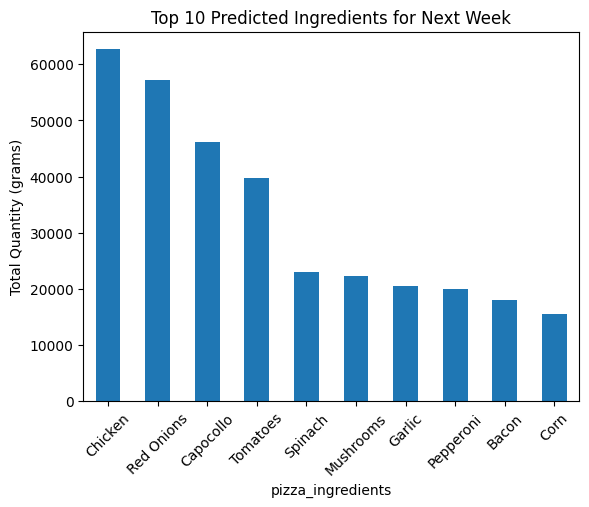

In [123]:
plt.figure(figsize=(12, 8))
ingredients_total.nlargest(10, 'total_ingredients_qty').plot(kind='bar', x='pizza_ingredients', y='total_ingredients_qty', legend=False)
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45)
plt.show()